# 워드클라우드

* 프로세스
    1. 데이터로드 
    - 데이터 탐색
    - 분석 범주 선정
    - 텍스트 전처리(이메일, ip주소, 특수기호 제거)
    - 추출 품사 선정
    - 형태소 분석
    - 빈도표 생성
    - 단어 정제(불용어, 오류 단어 등)
    - 빈도표 확인
    - 워드클라우드 설정(모양, 폰트, 색상)
    - 워드클라우드 그리기
    - 인사이트 도출

**1.데이터로드**

In [8]:
import pandas as pd

#데이터 로드
lg = pd.read_excel("/home/lab543/jupyter/00. Project/sk매직/data/엘지식기세척기_v2.xlsx")
sam = pd.read_excel("/home/lab543/jupyter/00. Project/sk매직/data/삼성식기세척기_v2.xlsx")
tri = pd.read_excel("/home/lab543/jupyter/00. Project/sk매직/data/트리플케어식기세척기_v2.xlsx")

data = pd.concat([lg,sam,tri])

#데이터 탐색
print("관측치 수:"+str(len(data)))
data.head(2)

관측치 수:245


,keyword,site,category,date,title,content,username,link
0,LG 식기세척기,naverBlog,경쟁사,2020-02-25,LG DIOS 12인용 식기세척기 6개월간 사용후기,LG DIOS 식기세척기 DFB22M 빌트인 12인용 모델을 사용한 지도 어연 6...,민기린 mingirin,https://m.blog.naver.com/chongchong29?Redirect...
1,LG 식기세척기,naverBlog,경쟁사,2019-11-30,LG식기 세척기 솔직 후기 (세제남음 ㅠㅠ),그동안 가전은 LG라고 생각하며 살아왔던나.#식기세척기 역시 LG로​친구들도 다 ...,favoreun,https://m.blog.naver.com/favoreun?Redirect=Log...


**2.데이터 탐색**

In [9]:
#키워드
data['keyword'].value_counts()

LG 식기세척기       112
삼성 식기세척기        83
트리플케어 식기세척기     50
Name: keyword, dtype: int64

In [10]:
#결측치
pd.isnull(data['title']).sum(), pd.isnull(data['content']).sum()

(0, 0)

**3.분석 범주 선정**

In [73]:
k = '트리플케어 식기세척기'
keyword_data = data[data['keyword'] == k].reset_index().drop(['index'], axis =1)

In [74]:
keyword_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
keyword     50 non-null object
site        50 non-null object
category    50 non-null object
date        50 non-null object
title       50 non-null object
content     50 non-null object
username    50 non-null object
link        50 non-null object
dtypes: object(8)
memory usage: 3.2+ KB


**4.텍스트 전처리(이메일, ip주소, 특수기호, 숫자 제거)**

In [75]:
text_data = keyword_data['title']+' '+keyword_data['content']

In [76]:
import re

url = "(https?://)?(www.)?[a-zA-Z0-9./?=&-_]+[.]?[/][a-zA-Z0-9./?=&-_%]+"
email = "[-_.+a-zA-Z0-9]+[@].+[.][[a-zA-Z0-9]+|[a-zA-Z0-9]+[.][a-zA-Z0-9]+]"
special = "(u200b)|[^(가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9 )]"

for i in range(len(text_data)):
    text_data[i] = re.sub(url,"", text_data[i])
    text_data[i] = re.sub(email,"", text_data[i])
    text_data[i] = re.sub(special,"", text_data[i])
    text_data[i] = text_data[i].lower()

**5.형태소 분석**

**1)형태소 자르기**

In [77]:
import time
from khaiii import KhaiiiApi

# 보완 필요 - 1차원적인 해결법
text_data = text_data[(text_data != '  ')&(text_data != '   ')].reset_index().drop(['index'],axis=1)
text_data = text_data[0]

# noun ='[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/NNG)|[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/NNP)'
# forign = '[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/SL)'
# adjective = '[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/VA)'
# verb = '[ㄱ-ㅎ가-힣a-zA-Z]{2,}(?=\/VV)'


noun ='[가-힣a-zA-Z]{2,}(?=\/NNG)|[가-힣a-zA-Z]{2,}(?=\/NNP)'
adjective = '[가-힣a-zA-Z]{2,}(?=\/VA)'
verb = '[가-힣a-zA-Z]{2,}(?=\/VV)'
num = '[0-9]{2,}(?=\/SN)'

document = list()
# n = re.compile(noun+'|'+forign+'|'+adjective+'|'+verb+'|'+num)
n = re.compile(noun+'|'+adjective+'|'+verb)

start = time.time()

for i in range(len(text_data)):
    word = list()
    for text in KhaiiiApi().analyze(text_data[i]):
        temp = str(text).split("\t")[1].split('+')
        word.extend(n.findall(str(temp)))
    document.append(word)
    

print("time:",time.time() - start)

time: 2.614542007446289


**2)n-gram 사용**

In [78]:
#빈도수 확인을 위해 리스트 자료 텍스트 자료로 변환
word_list = list()

for i in document:
    w = ' '.join(i)
    word_list.append(w) #

In [79]:
# n-gram
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(ngram_range = (1,3))
X1 = vectorizer.fit_transform(word_list)
words = (vectorizer.get_feature_names())

In [80]:
# 사전 도입
design_dict = ['깔끔','이쁘','디자인','예쁘','이뻐','색상','색깔','블랙','화이트','외관']

price = list()
design = list()

for j in range(len(design_dict)):
    for i in range(len(words)):
        if design_dict[j] in words[i]:
            design.append(words[i])

In [83]:
design[:10]

['결깔끔',
 '결깔끔 사용',
 '결깔끔 사용 설거지',
 '공간 깔끔',
 '공간 깔끔 신혼집',
 '깔끔',
 '깔끔 마감',
 '깔끔 마감 처리',
 '깔끔 신혼집',
 '깔끔 신혼집 파트']

In [96]:
d =''

for i in range(len(design)):
    d = d + ' ' + design[i]

dd = d.split(' ')

In [97]:
# 생성
word_count = pd.DataFrame(dd, columns=['word']).groupby('word').size().reset_index(name='count').sort_values(['count'], ascending=False).reset_index(drop=True)

In [99]:
word_count[:30]

,word,count
0,디자인,235
1,블랙,172
2,예쁘,144
3,화이트,88
4,색상,74
5,주방,43
6,이쁘,39
7,그레이스,35
8,선택,29
9,설치,28


In [17]:
# #단어 수정
# word_count.loc[word_count['word'] == '식기_세척기','word'] = '식기세척기'
# word_count.loc[word_count['word'] == 'dfb_22','word'] = 'dfb22'
# word_count.loc[word_count['word'] == 'lg_디오스','word'] = 'lg_dios'
# word_count.loc[word_count['word'] == '편하','word'] = '편한'
# word_count.loc[word_count['word'] == '좋아하','word'] = '좋아한'
# word_count.loc[word_count['word'] == 'dw','word'] = 'DW50R4055FS'
# word_count.loc[word_count['word'] == '블랙','word'] = '그래이스 블랙'

#불용어 제거
add_line = list()

#공용
add_line.extend(['사용','설거지','세척','그릇','식기','식기세척기','제품','나오','이렇','돌리','생각','정도','가능','구매','부분',\
                 '필요','주방','들어가','보이','선택','고민','그렇','싱크대','비교','후기','처음','경우','사용_후기','식세기',\
                 '건조기','구입','생기','화질_선택','접시','느끼','느낌','확인','기사','세척기','모르','요즘','아래','사람','그러',\
                 '위하','열리','코스','정리','ㅋㅋ','모델','따르','만들','닦이','가전','걱정','가격','제거','끝나','저녁','수저',\
                 '올리','누르','이상','이용','헹구','사진','걸리','꺼내','청소','하루','모습','작동','문제','포스팅','쌓이','진짜',\
                 '공사','차이','설정','방법','모드','시작','지금','빌트','날개','대하','버튼','아침','다르','관리','동안','이사',\
                 '음식물','완료','선반','상단','원래','100_트루','이번','돌아가','설명','이제','다음','상태','기본','자동','씻기',\
                 '음식','추가','설거','자리','바꾸','어떻','설치','업체','12','00_00','10','1080','30','20','한국','인용','청소기',\
                 '업체','마음','재생','검색','진행','이유','엄마','60','인터넷','com','기존','알리','기다리','결정','일반','맞추',\
                 '준비','내돈','표준','오늘','완전','떨어지','중요','가지','방문','아파트','들어오','100','24','2019_12'])

# 엘지
# add_line.extend(['lg','lg_식기세척기','sk','엘지',lg_전자'])

# 삼성
# add_line.extend(['삼성_식기','삼성','50_4055','fs','알아보','삼성_식기세척기','세척기_프리'])

# 트리플케어
add_line.extend(['sk_매직','트리플케어_식기','ml','sk','트리플케','케어','하단','세척_건조','kg','와이드','컴팩트','화질',\
                 '트리플케어','매직_트리플케어','세트','옵션_1080','보관','세척_가능','출시','바구니','타공','다양',\
                 '플케_어식기세척기','듀얼','상황','도어','구멍','타입','그레이스','매직','박스','식사','버튼_누르','도와주',\
                 '맛있','덕분','하트박스','위치','여유','고르',])

# for i in range(len(add_line)):
#     word_count = word_count[word_count['word'] != add_line[i]].reset_index().drop(['index'],axis = 1)
    
# import numpy as np

# new_count = word_count.groupby(['word']).sum().sort_values(['count'], ascending=False).astype(int)['count']
# new_word = word_count.groupby(['word']).sum().sort_values(['count'], ascending=False).index
# word_count = pd.DataFrame(list(zip(new_word,new_count)),columns=['word','count'])

**6.빈도표 확인**

**1)정제 전 빈도표**

In [114]:
import itertools
words = list(itertools.chain(*tri_result))

# 생성
word_count = pd.DataFrame(words, columns=['word']).groupby('word').size().reset_index(name='count').sort_values(['count'], ascending=False).reset_index(drop=True)

**2)정제하기**

In [119]:
#단어 수정
word_count.loc[word_count['word'] == '식기_세척기','word'] = '식기세척기'
word_count.loc[word_count['word'] == 'dfb_22','word'] = 'dfb22'
word_count.loc[word_count['word'] == 'lg_디오스','word'] = 'lg_dios'
word_count.loc[word_count['word'] == '편하','word'] = '편한'
word_count.loc[word_count['word'] == '좋아하','word'] = '좋아한'
word_count.loc[word_count['word'] == 'dw','word'] = 'DW50R4055FS'
word_count.loc[word_count['word'] == '블랙','word'] = '그래이스 블랙'

#불용어 제거
add_line = list()

#공용
add_line.extend(['사용','설거지','세척','그릇','식기','식기세척기','제품','나오','이렇','돌리','생각','정도','가능','구매','부분',\
                 '필요','주방','들어가','보이','선택','고민','그렇','싱크대','비교','후기','처음','경우','사용_후기','식세기',\
                 '건조기','구입','생기','화질_선택','접시','느끼','느낌','확인','기사','세척기','모르','요즘','아래','사람','그러',\
                 '위하','열리','코스','정리','ㅋㅋ','모델','따르','만들','닦이','가전','걱정','가격','제거','끝나','저녁','수저',\
                 '올리','누르','이상','이용','헹구','사진','걸리','꺼내','청소','하루','모습','작동','문제','포스팅','쌓이','진짜',\
                 '공사','차이','설정','방법','모드','시작','지금','빌트','날개','대하','버튼','아침','다르','관리','동안','이사',\
                 '음식물','완료','선반','상단','원래','100_트루','이번','돌아가','설명','이제','다음','상태','기본','자동','씻기',\
                 '음식','추가','설거','자리','바꾸','어떻','설치','업체','12','00_00','10','1080','30','20','한국','인용','청소기',\
                 '업체','마음','재생','검색','진행','이유','엄마','60','인터넷','com','기존','알리','기다리','결정','일반','맞추',\
                 '준비','내돈','표준','오늘','완전','떨어지','중요','가지','방문','아파트','들어오','100','24','2019_12'])

# 엘지
# add_line.extend(['lg','lg_식기세척기','sk','엘지',lg_전자'])

# 삼성
# add_line.extend(['삼성_식기','삼성','50_4055','fs','알아보','삼성_식기세척기','세척기_프리'])

# 트리플케어
add_line.extend(['sk_매직','트리플케어_식기','ml','sk','트리플케','케어','하단','세척_건조','kg','와이드','컴팩트','화질',\
                 '트리플케어','매직_트리플케어','세트','옵션_1080','보관','세척_가능','출시','바구니','타공','다양',\
                 '플케_어식기세척기','듀얼','상황','도어','구멍','타입','그레이스','매직','박스','식사','버튼_누르','도와주',\
                 '맛있','덕분','하트박스','위치','여유','고르',])

for i in range(len(add_line)):
    word_count = word_count[word_count['word'] != add_line[i]].reset_index().drop(['index'],axis = 1)
    
import numpy as np

new_count = word_count.groupby(['word']).sum().sort_values(['count'], ascending=False).astype(int)['count']
new_word = word_count.groupby(['word']).sum().sort_values(['count'], ascending=False).index
word_count = pd.DataFrame(list(zip(new_word,new_count)),columns=['word','count'])

**3)정제 후 빈도표**

In [120]:
word_count[:50]

,word,count
0,건조,111
1,기능,81
2,시간,79
3,공간,61
4,디자인,55
5,내부,53
6,아이,52
7,세제,49
8,편한,47
9,젖병,43


In [15]:
#검색
pd.set_option('display.max_colwidth',200)
w = '국화'
keyword_data[keyword_data['content'].str.contains(w)].head(3)

,keyword,site,category,date,title,content,username,link
105,LG 식기세척기,naverBlog,경쟁사,2020-02-05,LG식기세척기 빌트인 (feat. 주방키큰장 공사)내돈주고 산 후기,?안녕하세요. 문언냐에요^^?결혼 10주년을 맞이하여?남편에게 LG식기세척기를 선물 받았어요.?여행을 갈까 가방 선물을 받을까?행복한 고민을 했었으나...?살면서 도움이 되는 걸로?결국 lg식기세척기를 선택했어요.ㅋㅋ이왕 사는거 제일 신상으로..?제가 선택한 모델은?DFB22M-1 로 검은색을 구매했어요.?lg식기세척기 4가지 특징을 가지고 있는데요...,문언냐,https://m.blog.naver.com/kimshmoon?Redirect=Log&logNo=221797392974


**7.워드클라우드 설정 및 그리기**

In [121]:
import numpy as np
from PIL import Image
import requests

# 폰트 타입
font_path = '/home/lab543/jupyter/fonts/NotoSansCJKkr-Bold.otf'

# 워드 모양
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Disk_pack1.svg/1200px-Disk_pack1.svg.png'

mask = np.array(Image.open(requests.get(url, stream=True).raw))

In [122]:
word_dict = dict()
for i in range(30):
    word_dict[word_count['word'][i]] = word_count['count'][i]

**1)엘지 식기세척기**

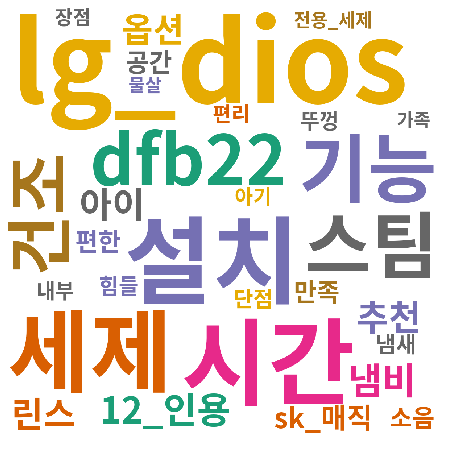

In [70]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# %matplotlib inline
# wc = WordCloud(font_path = font_path,
#                min_font_size = .5,
#                colormap = 'Dark2',
#                background_color='white', 
#                width=800,
#                height=800,
#                mask = mask)

# cloud = wc.generate_from_frequencies(word_dict)
# plt.figure(figsize=(10,8))
# plt.axis('off')
# plt.imshow(cloud)

**2)삼성 식기세척기**

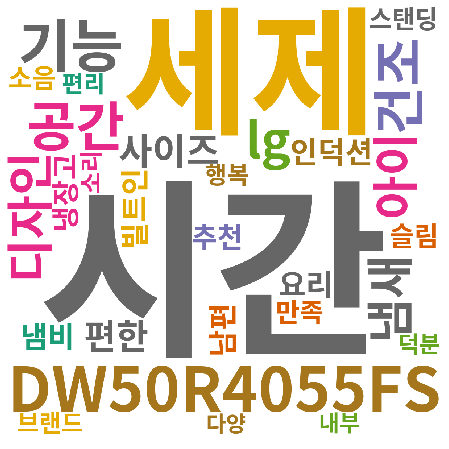

In [106]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# %matplotlib inline
# wc = WordCloud(font_path = font_path,
#                min_font_size = .5,
#                colormap = 'Dark2',
#                background_color='white', 
#                width=800,
#                height=800,
#                mask = mask)

# cloud = wc.generate_from_frequencies(word_dict)
# plt.figure(figsize=(10,8))
# plt.axis('off')
# plt.imshow(cloud)

**3)트리플케어**

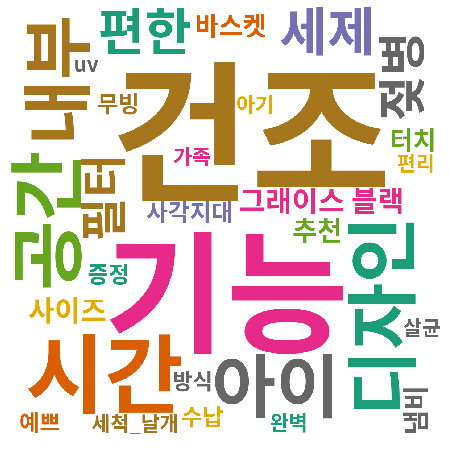

In [123]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline
wc = WordCloud(font_path = font_path,
               min_font_size = .5,
               colormap = 'Dark2',
               background_color='white', 
               width=800,
               height=800,
               mask = mask)

cloud = wc.generate_from_frequencies(word_dict)
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)